# **프로젝트 제목 : 서울시 공유 자전거 수요 예측**

## <b> 데이터 설명 </b>

### <b> 데이터셋에는 날씨 정보(온도, 습도, 풍속, 가시성, 이슬점, 일사량, 강설량, 강우량), 시간당 대여 자전거 수, 날짜 정보가 포함되어 있습니다</b>


### <b>속성 정보: </b>

* #### Date : 년월일
* #### Rented Bike count - 시간대별 대여 자전거 수
* #### Hour - 하루의 시간
* #### Temperature-온도(섭씨 단위)
* #### Humidity - 습도%
* #### Windspeed - 풍속m/s
* #### Visibility - 가시거리 10m
* #### Dew point temperature - 노점온도 섭씨
* #### Solar radiation - 일사량 MJ/m2
* #### Rainfall - 강우량 mm
* #### Snowfall - 강설량 cm
* #### Seasons - 계절 (봄,여름,가을,겨울)
* #### Holiday - 휴일/휴일없음
* #### Functional Day - 비기능시간, 기능시간

In [833]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV,  cross_val_score
from sklearn import preprocessing, linear_model
from sklearn.preprocessing import  LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
from sklearn.svm import SVR
from sklearn import tree

import warnings
warnings.filterwarnings('ignore')

pd.pandas.set_option('display.max_columns',None)
%matplotlib inline

In [834]:
import io
import pandas as pd
data = pd.read_csv('SeoulBikeData.csv',encoding = 'unicode_escape') #since the data set contains non-ASCII characters 'encoding' is requiered

In [835]:
#데이터셋 뷰
data.head(5)

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [836]:
#데이터셋에 대한 정보
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

In [837]:
#컬럼 정보 확인
data.columns

Index(['Date', 'Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day'],
      dtype='object')

In [838]:
#중복 데이터 확인
len(data[data.duplicated()])

0

In [839]:
# 행과 열이 몇 개 있는지 확인
data.shape

(8760, 14)

In [840]:
# 각 열의 총 null 값 확인
data.isnull().sum().sort_values(ascending=False)

Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64

# **데이터 필터링**

In [841]:
#데이터를 처리하기 전에 데이터 집합 복사본 생성
Bike_data = data.copy()

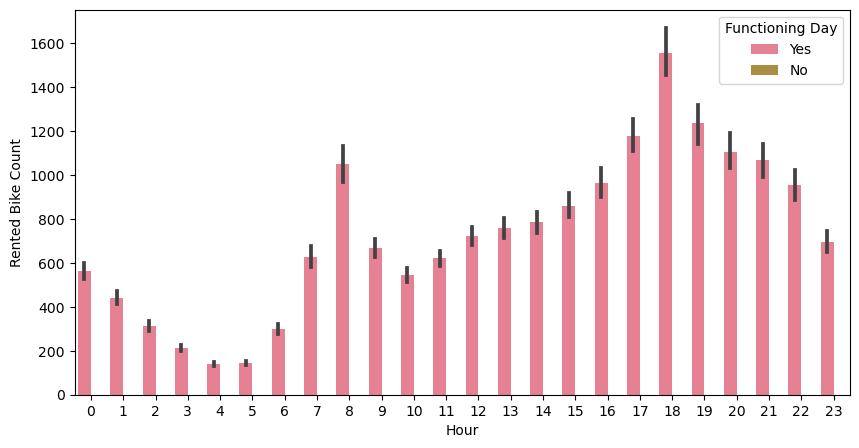

In [842]:
#기능중인 요일 및 비기능중인 요일 확인, 그림(시간 대 대여 자전거 수 그래프)
def barplots(x,y,hue):
    plt.figure(figsize=(10,5))
    sns.set_palette("husl")
    sns.barplot(x=x,y=y,hue=hue,data= Bike_data);
barplots('Hour','Rented Bike Count','Functioning Day')

In [843]:
# 기능일별 그룹화 및 총 대여 자전거 수 계산
Bike_data.groupby('Functioning Day').sum()['Rented Bike Count'].sort_values(ascending = False).reset_index()

,Functioning Day,Rented Bike Count
0,Yes,6172314
1,No,0


데이터 확인시 대여 자전거는 기능하는 날에만 제공되므로 기능하지 않는 날을 제거한 다음 기능하는 날 열도 제거합니다.

In [844]:
#비기능일 데이터 제거
Bike_data = Bike_data.drop(Bike_data[Bike_data['Functioning Day'] == 'No'].index)

In [845]:
# "Functioning Day" 컬럼 삭제
Bike_data =Bike_data.drop(['Functioning Day'], axis = 1)

print("자전거 대여일만 있는 필터링된 데이터 프레임 :",Bike_data.shape,"\n")

자전거 대여일만 있는 필터링된 데이터 프레임 : (8465, 13) 



## 데이터 탐색적 분석

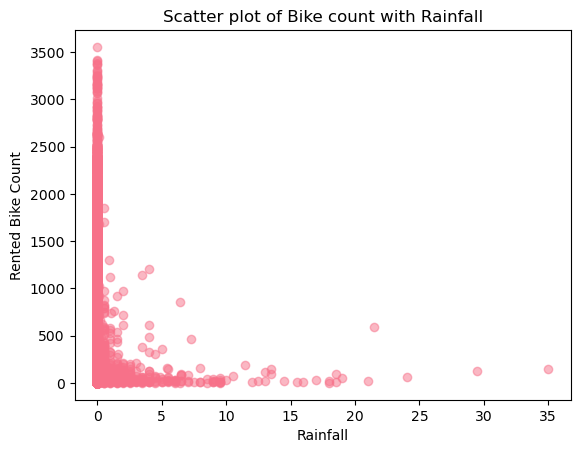

In [846]:
#공유 자전거 수와 강우량 사이의 그래프
plt.scatter(data['Rainfall(mm)'], data['Rented Bike Count'], alpha=0.5)
plt.title('Scatter plot of Bike count with Rainfall')
plt.xlabel('Rainfall')
plt.ylabel('Rented Bike Count')
plt.show()

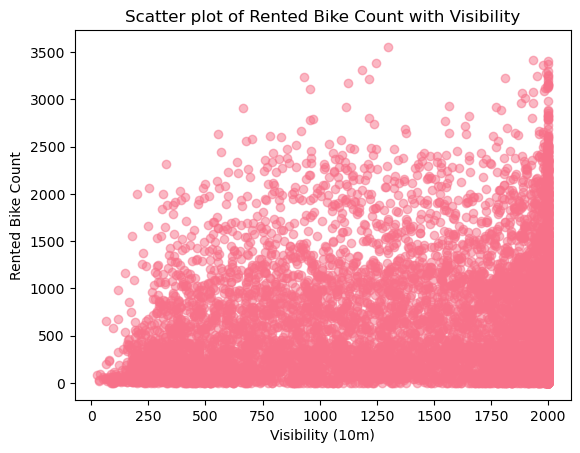

In [847]:
#공유 자전거 수와 가시성 사이의 그래프
plt.scatter(data['Visibility (10m)'], data['Rented Bike Count'], alpha=0.5)
plt.title('Scatter plot of Rented Bike Count with Visibility')
plt.xlabel('Visibility (10m)')
plt.ylabel('Rented Bike Count')
plt.show()

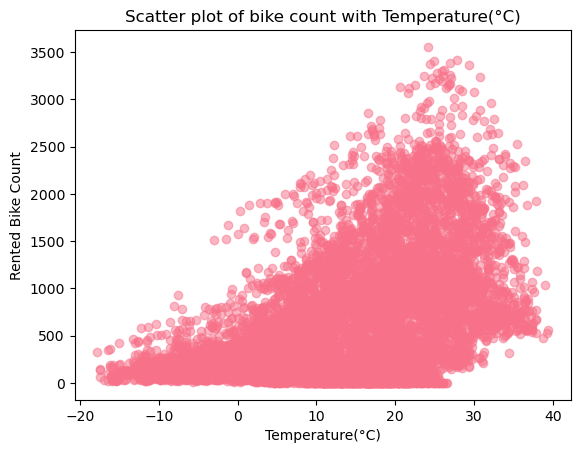

In [848]:
#공유 자전거 수와 온도 사이의 그래프
plt.scatter(data['Temperature(°C)'], data['Rented Bike Count'], alpha=0.5)
plt.title('Scatter plot of bike count with Temperature(°C)')
plt.xlabel('Temperature(°C)')
plt.ylabel('Rented Bike Count')
plt.show()

수치속성 분포를 관찰

In [849]:
numeric_features = data.describe().columns
numeric_features

Index(['Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)'],
      dtype='object')

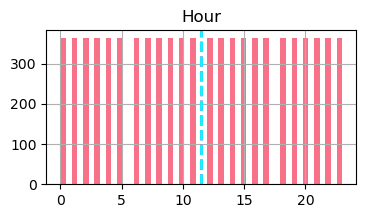

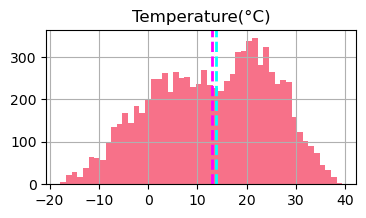

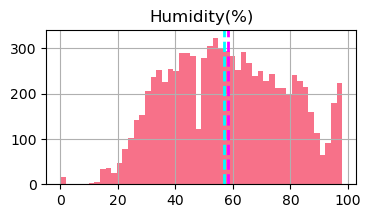

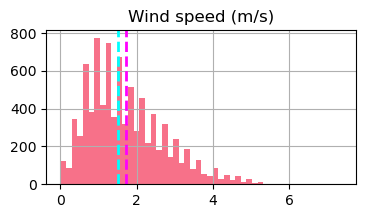

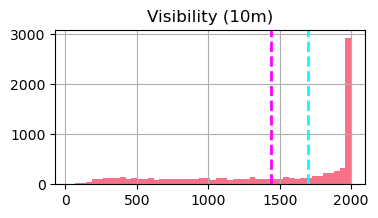

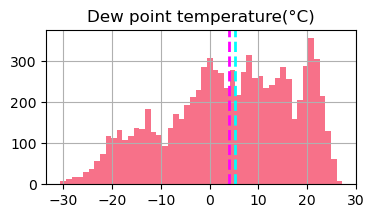

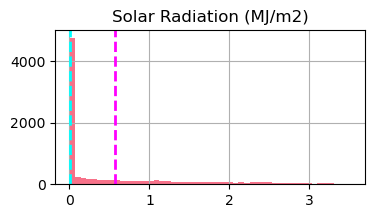

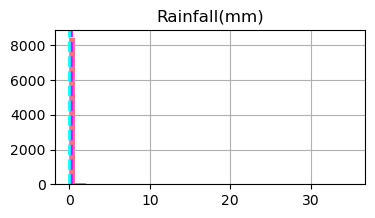

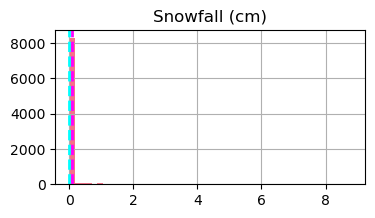

In [850]:
#plot for numerical attributions
for col in numeric_features[1:]:
    fig = plt.figure(figsize=(4, 2))
    ax = fig.gca()
    feature = data[col]
    feature.hist(bins=50, ax = ax)
    ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
    ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)
    ax.set_title(col)
plt.show()

<AxesSubplot:>

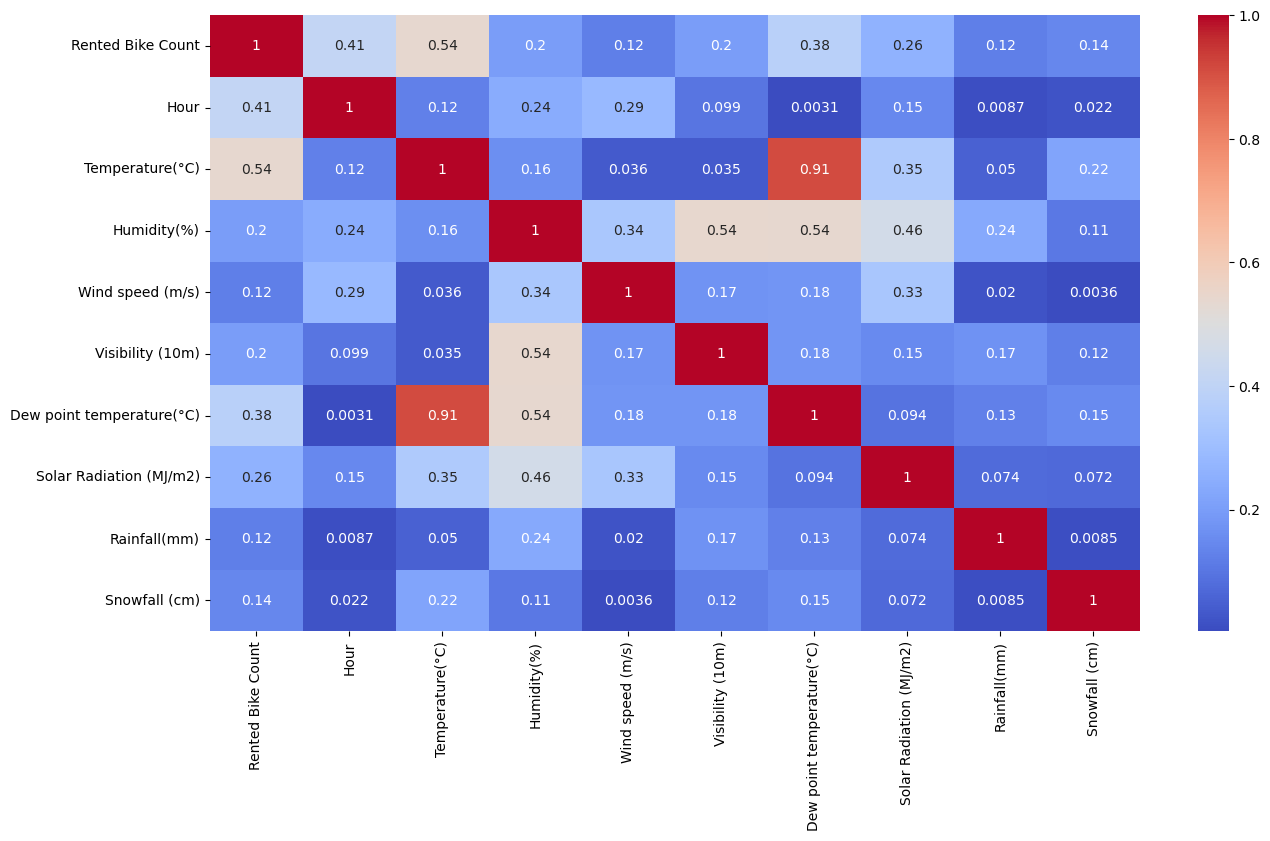

In [851]:
 ## 상관관계
plt.figure(figsize=(15,8))
correlation = data.corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')

온도와 이슬점 온도는 거의 0.91로 상관관계가 있기 때문에 다중 공선성 문제가 발생합니다. 
그래서 우리는 이슬점 온도 열을 제거합니다

In [852]:
# "Dew point temperature(°C)" 열 제거
Bike_data.drop(columns=['Dew point temperature(°C)'],inplace=True)

Nuemerical Variable

In [853]:
numeric_features = Bike_data.describe().columns
print(numeric_features)

Index(['Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Solar Radiation (MJ/m2)',
       'Rainfall(mm)', 'Snowfall (cm)'],
      dtype='object')


Categorical variable

In [854]:
#For categorical Data
categorical_features=[col for col in Bike_data.columns if Bike_data[col].dtype=='O']
categorical_features

['Date', 'Seasons', 'Holiday']

In [855]:
#convert in datetime64[ns] datatype
Bike_data['Date'] = pd.to_datetime(Bike_data['Date'])
Bike_data['Date']

0      2017-01-12
1      2017-01-12
2      2017-01-12
3      2017-01-12
4      2017-01-12
          ...    
8755   2018-11-30
8756   2018-11-30
8757   2018-11-30
8758   2018-11-30
8759   2018-11-30
Name: Date, Length: 8465, dtype: datetime64[ns]

In [856]:
#Seperate Day, Month, Year from DataFrame Column

Bike_data['Day']= Bike_data['Date'].dt.day
Bike_data['Month']=Bike_data['Date'].dt.month
Bike_data['Year']=Bike_data['Date'].dt.year

In [857]:
 #drop the Date column after extracting necessory information
Bike_data.drop(columns=['Date'],inplace=True)

In [858]:
categorical_features1=[col for col in Bike_data.columns if Bike_data[col].dtype=='O']
categorical_features1


['Seasons', 'Holiday']

In [859]:
# 범주형 피쳐에 대한 데이터 프레임 분리
cat_data=Bike_data[categorical_features1]

In [860]:
# 범주형 피쳐의 고유 수
for feature in categorical_features1:
    print('The feature is {} and number of categories are {}'.format(feature,len(Bike_data[feature].unique())))

The feature is Seasons and number of categories are 4
The feature is Holiday and number of categories are 2


In [861]:
 #계절별 그룹화 및 총 대여 자전거 수 계산
Bike_data.groupby('Seasons').sum()['Rented Bike Count'].sort_values(ascending = False).reset_index()

,Seasons,Rented Bike Count
0,Summer,2283234
1,Autumn,1790002
2,Spring,1611909
3,Winter,487169


In [862]:
# 휴일별 그룹화 및 총 대여 자전거 수 계산
Bike_data.groupby('Holiday').sum()['Rented Bike Count'].sort_values(ascending = False).reset_index()

,Holiday,Rented Bike Count
0,No Holiday,5956419
1,Holiday,215895


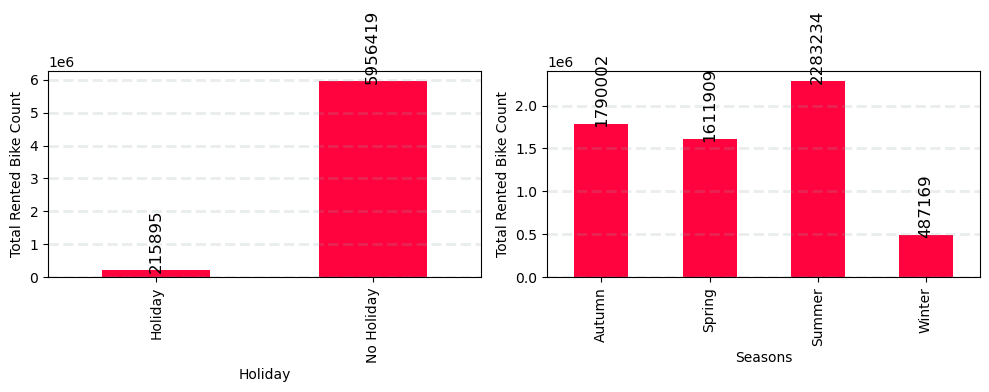

In [863]:
#범주형 변수와 종속 기능의 관계 알아보기 자전거 대여 수

fig = plt.figure(figsize = (10,4))
for index,column in enumerate(categorical_features1) :
    plt.subplot(1,2,index+1)
    dataset=Bike_data.copy()
    dataset.groupby(feature)['Rented Bike Count'].sum().plot(kind='bar',color="#ff033e")
    feature = Bike_data[column]
    ax = fig.gca()
    plt.ylabel('Total Rented Bike Count')
    plt.tight_layout()
    plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.2)
    for p in ax.patches:
        ax.annotate(round(p.get_height()),(p.get_x() + p.get_width()/2,p.get_height()),ha='center',size= 12, rotation=90)

공휴일에는 비공휴일에 비해 대여 자전거의 수가 적습니다.

겨울에는 대여 자전거 수가 매우 적습니다.

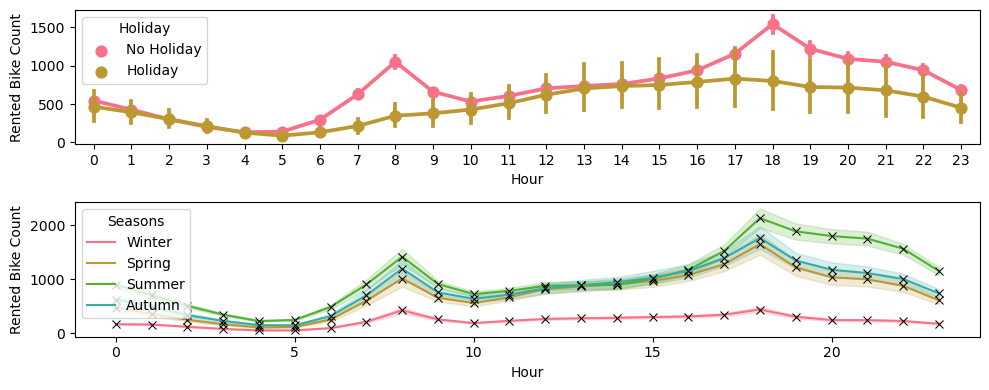

In [864]:
fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(10,4), dpi=100)
sns.pointplot(data=data, x="Hour", y="Rented Bike Count", ax=axs[0],
              hue="Holiday")
sns.lineplot(data=data, x="Hour", y="Rented Bike Count", ax=axs[1],
              hue="Seasons", marker="x",markeredgecolor="black")
plt.tight_layout()

In [865]:
#라벨 인코딩 적용
label_df= Bike_data.apply(LabelEncoder().fit_transform)
label_df

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Day,Month,Year
0,252,0,111,28,22,1779,0,0,0,3,1,11,0,0
1,202,1,108,29,8,1779,0,0,0,3,1,11,0,0
2,171,2,103,30,10,1779,0,0,0,3,1,11,0,0
3,105,3,101,31,9,1779,0,0,0,3,1,11,0,0
4,76,4,103,27,23,1779,0,0,0,3,1,11,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,990,19,205,25,26,1673,0,0,0,0,1,29,10,1
8756,754,20,197,28,23,1779,0,0,0,0,1,29,10,1
8757,685,21,189,30,3,1747,0,0,0,0,1,29,10,1
8758,703,22,184,32,10,1639,0,0,0,0,1,29,10,1


Checking Season Column Data

In [866]:
#for checking raw data
Bike_data.groupby("Seasons").count()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Day,Month,Year
Seasons,,,,,,,,,,,,,
Autumn,1937,1937,1937,1937,1937,1937,1937,1937,1937,1937,1937,1937,1937
Spring,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160
Summer,2208,2208,2208,2208,2208,2208,2208,2208,2208,2208,2208,2208,2208
Winter,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160


In [867]:
 #Seasons convert to numerical after apply transformation on data
label_df.groupby('Seasons').count()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Day,Month,Year
Seasons,,,,,,,,,,,,,
0,1937,1937,1937,1937,1937,1937,1937,1937,1937,1937,1937,1937,1937
1,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160
2,2208,2208,2208,2208,2208,2208,2208,2208,2208,2208,2208,2208,2208
3,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160,2160


0 : Autumn , 1 : Spring , 2 : Summer , 3 : Winter

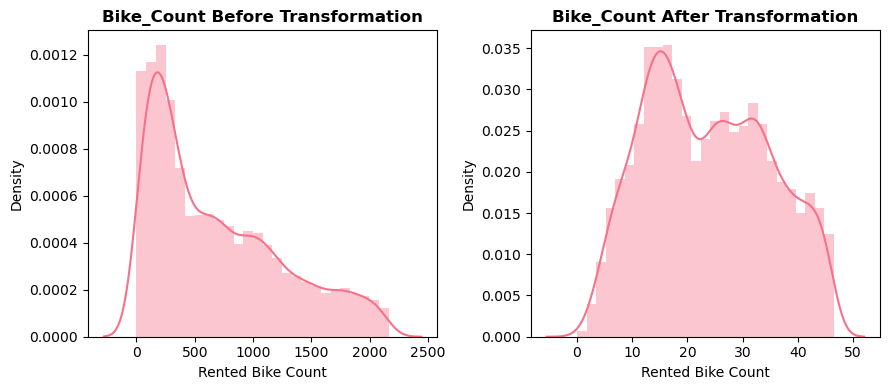

In [868]:
plt.figure(figsize=(9,4))
plot = plt.subplot(1,2,1)
sns.distplot(label_df['Rented Bike Count']).set_title('Bike_Count Before Transformation',weight='bold')
plot = plt.subplot(1,2,2)
sns.distplot(np.sqrt(label_df['Rented Bike Count'])).set_title('Bike_Count After Transformation',weight='bold')
plt.tight_layout()

In [869]:
scaler = MinMaxScaler()
features = [i for i in label_df.columns if i not in ['Rented Bike Count']]
independent_variables = [i for i in label_df.columns if i not in ['Rented Bike Count']]

# **훈련 세트와 테스트 세트 만들기**

In [870]:
#X 및 y 변수 또는 독립 및 종속 변수 정의
X = label_df.drop('Rented Bike Count',axis=1)
y = np.sqrt(label_df['Rented Bike Count'])
#데이터 분할
X_train, X_test, y_train, y_test = train_test_split( X,y , test_size = 0.2, random_state = 42)

In [871]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

6772
6772
1693
1693


In [872]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("minmax", MinMaxScaler()),
])

In [873]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), MinMaxScaler())

from sklearn import set_config

set_config(display='diagram')

num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('minmaxscaler', MinMaxScaler())])

In [874]:
bike_num_prepared = num_pipeline.fit_transform(label_df)
bike_num_prepared[:2].round(2)

array([[0.12, 0.  , 0.2 , 0.31, 0.34, 1.  , 0.  , 0.  , 0.  , 1.  , 1.  ,
        0.37, 0.  , 0.  ],
       [0.09, 0.04, 0.2 , 0.33, 0.12, 1.  , 0.  , 0.  , 0.  , 1.  , 1.  ,
        0.37, 0.  , 0.  ]])

In [875]:
print(type(label_df))
print(type(bike_num_prepared))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [876]:
num_pipeline.steps

[('simpleimputer', SimpleImputer(strategy='median')),
 ('minmaxscaler', MinMaxScaler())]

In [877]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Rented Bike Count", "Hour", "Temperature(°C)", "Humidity(%)",
               "Wind speed (m/s)", "Visibility (10m)", "Dew point temperature(°C)",
               "Solar Radiation (MJ/m2)", "Rainfall(mm)", "Snowfall (cm)"]
cat_attribs = ["Seasons", "Holiday"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))   

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

In [878]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

bike_prepared = preprocessing.fit_transform(data)

In [879]:
bike_prepared

<8760x383 sparse matrix of type '<class 'numpy.float64'>'
	with 101037 stored elements in Compressed Sparse Row format>

In [880]:
bike_num_prepared[:2].round(2)

array([[0.12, 0.  , 0.2 , 0.31, 0.34, 1.  , 0.  , 0.  , 0.  , 1.  , 1.  ,
        0.37, 0.  , 0.  ],
       [0.09, 0.04, 0.2 , 0.33, 0.12, 1.  , 0.  , 0.  , 0.  , 1.  , 1.  ,
        0.37, 0.  , 0.  ]])

In [881]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f85e2bbb190>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f85b55b86d0>)])),
                ('linearregression', LinearRegression())])

In [882]:
bike_predictions = lin_reg.predict(X_train)
bike_predictions[:5].round(-2)  # -2 = rounded to the nearest hundred

array([0., 0., 0., 0., 0.])

In [883]:
y_train.iloc[:5].values

array([12.84523258, 41.25530269, 31.22498999, 40.71854614, 36.70149861])

In [884]:
# extra code – computes the error ratios discussed in the book
error_ratios = bike_predictions[:5].round(-2) / y_train.iloc[:5].values - 1
print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

-100.0%, -100.0%, -100.0%, -100.0%, -100.0%


In [885]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(y_train, bike_predictions, squared=False)
lin_rmse

6.684296745905223

In [886]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f85e2bbb190>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f85b55b86d0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [887]:
bike_predictions = tree_reg.predict(X_train)
tree_rmse = mean_squared_error(y_train, bike_predictions, squared=False)
tree_rmse

0.0

In [888]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, X_train, y_train,scoring="neg_root_mean_squared_error", cv=10)
pd.Series(tree_rmses).describe()

count    10.000000
mean      5.049131
std       0.379889
min       4.513956
25%       4.837141
50%       5.071799
75%       5.201244
max       5.802547
dtype: float64

In [889]:
# extra code – computes the error stats for the linear model
lin_rmses = -cross_val_score(lin_reg, X_train, y_train,scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

count    10.000000
mean      6.695384
std       0.117515
min       6.519341
25%       6.619139
50%       6.683037
75%       6.732557
max       6.882706
dtype: float64

In [890]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)

In [891]:
pd.Series(forest_rmses).describe()

count    10.000000
mean      3.612572
std       0.206823
min       3.248152
25%       3.495210
50%       3.552103
75%       3.793959
max       3.910499
dtype: float64

In [892]:
forest_reg.fit(X_train, y_train)
bike_predictions = forest_reg.predict(X_train)
forest_rmse = mean_squared_error(y_train, bike_predictions, squared=False)
forest_rmse

1.3599492686409047

In [893]:
# 모델 분석 함수 추가
def analyse_model(model, X_train, X_test, y_train, y_test):
  
  # Fitting the model
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  a,p = y_test**2,y_pred**2

  # Calculating Evaluation Matrix
  mse = mean_squared_error(a,p)
  rmse = np.sqrt(mse)
  r2 = r2_score(a,p)
  try:
    importance = model.feature_importances_
    feature = features
  except:
    importance = np.abs(model.coef_)
    feature = independent_variables
  indices = np.argsort(importance)
  indices = indices[::-1]

  # Printing Evaluation Matrix
  print("MSE :" , mse)
  print("RMSE :" ,rmse)
  print("MAE :" ,mean_absolute_error(a,p))
  print("Train R2 :", r2_score(y_train**2,model.predict(X_train)**2))
  print("Test R2 :" ,r2)
  print("Adjusted R2 : ", 1-(1-r2)*((len(X_test)-1)/(len(X_test)-X_test.shape[1]-1)))

  return model

In [894]:
# 트리 수와 같은 하이퍼파라미터의 값 범위 제공:
n_estimators = [50,100,150]

# 트리의 최대 깊이:
max_depth = [6,8,10]

# 노드를 분할하는 데 필요한 최소 샘플 수:
min_samples_split = [50,100,150]

# 각 리프 노드에 필요한 최소 샘플 수:
min_samples_leaf = [40,50]

# 학습률:
eta = [0.05,0.08,0.1]

In [895]:
##**Linear Regressor**

In [896]:
# Linear Regression Model
lr = LinearRegression()

analyse_model(lr, X_train, X_test, y_train, y_test)

MSE : 114516.28182418182
RMSE : 338.4025440568995
MAE : 243.02495571545168
Train R2 : 0.6100784578188265
Test R2 : 0.6337243464837449
Adjusted R2 :  0.6308883825196523


LinearRegression()

In [897]:
##**Decision Tree Regressor**

In [898]:
# Decision Tree Regressor
regressor = DecisionTreeRegressor(random_state=42)

analyse_model(regressor, X_train, X_test, y_train, y_test)
print("---------------------------------------------------")
# HYperparameter Grid
grid = {'max_depth' : max_depth,
        'min_samples_split' : min_samples_split,
        'min_samples_leaf' : min_samples_leaf}

# GridSearch to find the best parameters
dt = GridSearchCV(regressor, param_grid = grid, scoring = 'neg_mean_squared_error', cv=5)
dt.fit(X_train, y_train)

# Analysing the model with best set of parametes
analyse_model(dt.best_estimator_, X_train, X_test, y_train, y_test)

MSE : 65647.49143532192
RMSE : 256.2176641750563
MAE : 155.05197873597166
Train R2 : 1.0
Test R2 : 0.7900291779985313
Adjusted R2 :  0.7884034360771381
---------------------------------------------------
MSE : 56972.53496920024
RMSE : 238.68920161833933
MAE : 159.3716771829107
Train R2 : 0.838256062844053
Test R2 : 0.8177756721934103
Adjusted R2 :  0.8163647631633414


DecisionTreeRegressor(max_depth=10, min_samples_leaf=40, min_samples_split=50,
                      random_state=42)

In [899]:
##**Random Forest Regressor**

In [900]:
# Random Forest Regressor
regressor = RandomForestRegressor(random_state=42)

analyse_model(regressor, X_train, X_test, y_train, y_test)
print("---------------------------------------------------")
# HYperparameter Grid
grid = {'n_estimators' : n_estimators,
        'max_depth' : max_depth,
        'min_samples_split' : min_samples_split,
        'min_samples_leaf' : min_samples_leaf}

# GridSearch to find the best parameters
rf = GridSearchCV(regressor, param_grid = grid, scoring = 'neg_mean_squared_error', cv=5)
rf.fit(X_train, y_train)

# Analysing the model with best set of parametes
analyse_model(rf.best_estimator_, X_train, X_test, y_train, y_test)

MSE : 38456.002608657145
RMSE : 196.1020209193601
MAE : 118.35738363692326
Train R2 : 0.9838576633595375
Test R2 : 0.8770000452098652
Adjusted R2 :  0.8760476929690839
---------------------------------------------------
MSE : 51005.63549544013
RMSE : 225.844272664684
MAE : 149.3436365585265
Train R2 : 0.8487037534267242
Test R2 : 0.8368605566255887
Adjusted R2 :  0.8355974162063705


RandomForestRegressor(max_depth=10, min_samples_leaf=40, min_samples_split=50,
                      n_estimators=50, random_state=42)